# PDHG Non-cartesian
This notebook applies the PDHG algorithm on a non-cartesian mask based on the paper "Learning the Sampling Pattern for MRI" published in June 2019. More details on the functions (and especially on the proximal operators) can be found there.

## Imports

In [1]:
# Package import
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN ,FFT
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask, \
    gridded_inverse_fourier_transform_nd
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data
from pysap.utils import save_image

/home/guillaume/temp/pysap-mri/mri/operators/fourier/cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "
/home/guillaume/temp/pysap-mri/mri/operators/fourier/non_cartesian.py:33: UserWarning: pynufft python package has not been found. If needed use the master release. Till then you cannot use NUFFT on GPU
  warnings.warn("pynufft python package has not been found. If needed use "



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [27]:
# Third party import
from modopt.math.metrics import ssim
from modopt.opt.linear import Identity
from modopt.opt.proximity import SparseThreshold

import numpy as np
import matplotlib.pyplot as plt
import random as rd
from PIL import Image
from modopt.math.matrix import PowerMethod

## Inputs

In [60]:
u0 = get_sample_data('2d-mri')

# Obtain MRI non-cartesian mask
radial_mask = get_sample_data("mri-radial-samples")
kspace_loc = radial_mask.data
mask = pysap.Image(data=convert_locations_to_mask(kspace_loc, u0.shape))

In [228]:
#Cartesian mask
mask = get_sample_data("mri-cartesian-mask")
kspace_loc = convert_mask_to_locations(mask.data)

In [229]:
mask.show()

### Test for creation of a mask from scratch (no import)

In [4]:
#Random mask
n=3000
kspace_loc = np.empty((n,2))
for i in range(n):
    kspace_loc[i]=[rd.random()-0.5,rd.random()-0.5]

In [222]:
m = convert_locations_to_mask(kspace_loc,(512,512))
mask = pysap.Image(data=m)
mask.show()

### Data
Observations: $y=S\mathcal{F}Ru+\epsilon$.

In [61]:
#Original image
image_rec0 = pysap.Image(data=np.abs(u0))
image_rec0.show()

In [92]:
# Adding noise
(n1,n2) = u0.shape
sigma = 1e-6
# Computing y with non-cartesian Fourier transform
fourier_op = NonCartesianFFT(samples=kspace_loc, shape=u0.shape,implementation='cpu')
y = fourier_op.op(u0.data)
y += np.asarray([np.random.normal(0,sigma)+np.random.normal(0,sigma)*1j for i in range(len(y))])
u0_mat = np.asarray(u0)

p=np.asarray([1 for i in range(len(y))])
pn1 = 1.2e-4
y *= p
y_temp = np.copy(y)

In [93]:
# Generate operators
# linear_op = WaveletUD2(
#     wavelet_id=24,
#     nb_scale=4,
# )
linear_op = WaveletN(
    wavelet_name='sym8',
    nb_scale=4)

In [94]:
# Tools for inverse fft
grid_space = np.linspace(-0.5, 0.5, num=u0.shape[0])
grid2D = np.meshgrid(grid_space, grid_space)

In [95]:
# Base reconstructed image: computes an inverse fft according to the mask on the noised data
grid_soln = gridded_inverse_fourier_transform_nd(kspace_loc, y,
                                                 tuple(grid2D), 'linear')
image_rec0 = pysap.Image(data=np.abs(grid_soln))
image_rec0.show()

In [194]:
ssim(grid_soln,u0)

0.6534402748833144

$\textbf{Remarque:}$ On a deja un gros écart en amplitude entre cette reconstruction à l'ordre 0 et l'image initiale avec le masque radial ($10^{-5}$ contre $10^{-8}$).

# Definition of functions to compute energy
Since S is a nxn diagonal matrix, we won't store it in memory and do all the computations directly with p

In [96]:
#constants
zeta = 1e5
epsilon = 1e-2
gamma = 1e-10
beta = 100

In [97]:
# functions B and G in the paper
def b(u):
    return np.sum([np.sum([max(0,-z**3)for z in u[i]]) for i in range(len(u))])*zeta
def g(u):return np.real(b(u)+epsilon*np.linalg.norm(u)**2/2)

In [98]:
# functions J and F2 in the paper
# We also compute rho and its first derivative since we will need it later
def rho(x):
    m = np.absolute(x)
    if m<gamma:
        return -m*m*m/3/gamma/gamma+m*m/gamma
    else:
        return m-gamma/3
def drho(x):
    if x<-gamma:return -1
    elif x<0:return x**2/gamma**2+2*x/gamma
    elif x<gamma:return -x**2/gamma**2+2*x/gamma
    else:return 1
    

def j(u):
    if len(u.shape)==1:
        return np.sum([rho(x) for x in u])
    else:
        return np.sum([np.sum([rho(x) for x in y])for y in u])
def f2(w): return pn1*j(w)

In [99]:
#function F1 in the paper
def R(u):
    return np.asarray([[np.real(u[i][j]) for j in range(len(u[0]))]for i in range(len(u))])
def Rstar(u):
    return np.array([[u[i][j]+0j for j in range(len(u[0]))]for i in range(len(u))])
def f1(v):
    return 0.5*np.linalg.norm((fourier_op.op(Rstar(v))-y)*p)**2

In [100]:
#PENALTY
def P(p):
    return beta*np.sum([[x*(2-x) for x in p[i]]for i in range(len(p))])

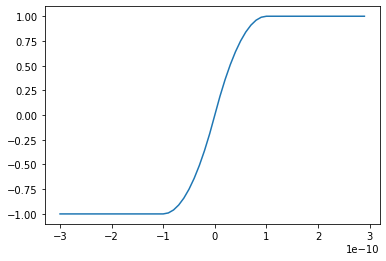

In [74]:
#First derivative of rho around 0
t = [0.1*i*gamma for i in range(-30,30)]
plt.plot(t,[drho(x) for x in t])

In [101]:
def energy(u):
    return(f1(Rstar(u))+f2(linear_op.op(u))+g(u))

In [76]:
print(energy(np.zeros(u0_mat.shape)))
print(energy(u0_mat))
print(energy(2*u0_mat))

0.000559570097844711
3.27631661567768e-08
0.0005595912155936036


In [41]:
print(f1(u0_mat))

3.272432306938654e-08


In [122]:
g(u0_mat)

1.9073484054388313e-07

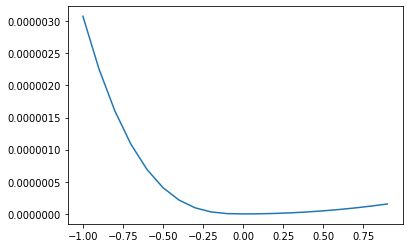

In [51]:
plt.plot([i/10 for i in range(-10,10)],[g(i*u0_mat/10) for i in range(-10,10)])

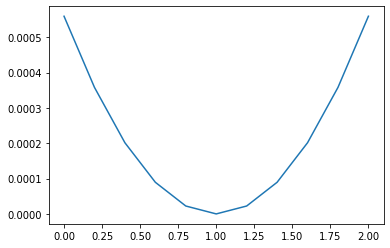

In [77]:
plt.plot([i/5 for i in range(11)],[energy(i*u0_mat/5)for i in range(11)])

# Proximal operators
The objective is to find the point minimizing $f_u(x) = F(x)+1/2||x-u||^2$ for a given u and for $F=\tau F1,\tau F2,\tau G$ where $\tau$ is a given constant.
## Proximal operator of F2
We want to minimize $f_u(x) = \tau\alpha (p)J(|x|)+\frac{1}{2}||x-u||^2$. As explained in the paper, given the definition of J, we can compute the solution component by component, but the paper expresses $x_i$ in terms of $u_i$ with a constant C that we need to compute. We have in 1D $f_u'(x) = \tau\alpha (p)\frac{x}{|x|}\rho '(|x|)+x-u$. Since $\rho '(x)$ depends on if $|x|<\gamma$ or not, we need to separate these two cases:
### |x|>$\gamma$
In this case, $\rho '(|x|)=1$, so we simply have $(1+\frac{\tau\alpha(p)}{|x|})x=u\Rightarrow x=(|u|-\tau\alpha(p))\frac{u}{|u|}$. Since we supposed $|x|<\gamma$ beforehand, this will be true when $|u|>\tau\alpha(p)+\gamma$.
### |x|$\leq\gamma$
From what we just saw, this is equivalent to $|u|\leq\tau\alpha(p)+\gamma$. This case is a bit more complicated, since now $\rho '(|x|)=-\frac{|x|^2}{\gamma^2}+2\frac{|x|}{\gamma}$ and taking the norm on both sides of $\tau\alpha (p)\frac{x}{|x|}\rho '(|x|)+x-u$ gives us:
$$-\frac{\tau\alpha(p)}{\gamma^2}|x|^2+(1+\frac{2\tau\alpha(p)}{\gamma})|x|-|u|=0\\
\Rightarrow |x| = \gamma+\frac{\gamma^2}{2\tau\alpha(p)}(1\pm\sqrt{\Delta})\\
with\ \Delta=1+\frac{4\tau\alpha(p)}{\gamma^2}(\gamma+\tau\alpha(p)-|u|)$$
But since we want $|x|<\gamma$, the only acceptable solution is $x=\left(\gamma+\frac{\gamma^2}{2\tau\alpha(p)}(1-\sqrt{\Delta})\right)\frac{u}{|u|}$. Since $|u|\leq\tau\alpha(p)+\gamma$, we see that $\Delta>1$, so the condition $|x|\leq\gamma$ is verified.

## Proximal operator of F1
The expression given in the paper is:
$$prox_{\tau F1}(u) = \mathcal{F}(I+\tau S(p)^2)^{-1}(\mathcal{F}u+\tau S(p)^2y)$$
with y the data.

## Proximal dual operators
We use the Moreau identity to compute the proximal dual operators:
$$prox_{\gamma\phi ^*}(x) = x-\gamma prox_{\phi/\gamma}(\frac{x}{\gamma})$$

In [102]:
#Prox_tauG
def prox_B(u,c):
    return np.asarray([[x/(0.5+np.sqrt(0.25-3*zeta*c*min(0,x)))for x in u[i]]for i in range(len(u))])
def prox_G(u,c):
    return prox_B(u/(1+epsilon),c/(1+epsilon))

In [15]:
y1 = prox_G(u0_mat,2)
y2 = y1+np.asarray([[np.random.normal(0,1e-7)for i in range(n2)]for j in range(n1)])

r1 = 2*g(y1)+0.5*np.linalg.norm(u0_mat-y1)**2
r2 = 2*g(y2)+0.5*np.linalg.norm(u0_mat-y2)**2
print("Distance between the two points:",np.linalg.norm(y1-y2))
print("Ratio (should always be smaller than 1 if v minimises the function as it is supposed to):"
                  ,np.abs(r1)/np.abs(r2))

Distance between the two points: 5.1279958204740124e-05
Ratio (should always be smaller than 1 if v minimises the function as it is supposed to): 0.9654616029877803


In [103]:
#Prox_tau/F2
def prox_F2(u,c):
    n = len(u)
    v = np.asarray([0+0j for i in range(n)])
    for i in range(n):
        mod_u = np.abs(u[i])
        if mod_u>c*pn1+gamma:
            v[i] = (mod_u-c*pn1)*u[i]/np.abs(u[i])
        else:
            delta = 1+4*c*pn1/(gamma**2)*(gamma+c*pn1-mod_u)
            v[i] = (gamma+gamma**2/(2*c*pn1)*(1-np.sqrt(delta)))*u[i]/np.abs(u[i])
    return v
def prox_F2_dual(u,c):
    return u-c*prox_F2(u/c,1/c)

In [17]:
c=2
x = np.asarray([1,2,3,4])
y1 = prox_F2(x,c)
y2 = y1+np.asarray([np.random.normal(0,1e-4)for i in range(4)])

r1 = c*f2(y1)+0.5*np.linalg.norm(x-y1)**2
r2 = c*f2(y2)+0.5*np.linalg.norm(x-y2)**2
print("Distance between the two points:",np.linalg.norm(y1-y2))
print("Ratio (should always be smaller than 1 if v minimises the function as it is supposed to):",r1/r2)

Distance between the two points: 0.00016569607747124205
Ratio (should always be smaller than 1 if v minimises the function as it is supposed to): 0.9999942799268857


In [104]:
#prox_tauF1
def prox_F1_paper(u,c):
    im=(fourier_op.op(u)+c*p*p*y)/(np.ones(y.shape)+c*p*p)
    return gridded_inverse_fourier_transform_nd(kspace_loc,im,tuple(grid2D),'linear')

def prox_F1(u,c):
    im = c*p*p*(fourier_op.op(u)-y)/(np.ones(y.shape)+c*p*p)
    return u-gridded_inverse_fourier_transform_nd(kspace_loc, im,
                                                 tuple(grid2D), 'linear')
def prox_F1_dual(u,c):
    return u-c*prox_F1(u/c,1/c)

In [19]:
c=2
y1 = prox_F1(u0_mat,c)
y2 = y1+np.asarray([[np.random.normal(0,1e-8)for i in range(n2)]for j in range(n1)])

r1 = c*f1(y1)+0.5*np.linalg.norm(u0_mat-y1)**2
r2 = c*f1(y2)+0.5*np.linalg.norm(u0_mat-y2)**2
print("Distance between the two points:",np.linalg.norm(y1-y2))
print("Ratio (should always be smaller than 1 if v minimises the function as it is supposed to):",r1/r2)

Distance between the two points: 5.131036480148482e-06
Ratio (should always be smaller than 1 if v minimises the function as it is supposed to): 0.9994557931161362


# Implementation of the PDHG algorithm

In [105]:
#constants
L=2
eta = max(np.amax(p)**2,pn1*j(np.reshape(u0_mat,(n1*n2,1))))
mu = 2*np.sqrt(epsilon/(1+L*L)/eta)
tau = mu/2/epsilon
sigma = mu*eta/2
theta = 1/(1+mu)

maxit = 20
tol = 1e-4

In [106]:
def step(uk,vk,wk,uk_bar):
    vk1 = prox_F1_dual(vk+sigma*uk_bar,sigma)
    wk1 = prox_F2_dual(wk+sigma*linear_op.op(uk_bar),sigma)
    uk1 = prox_G(uk-tau*R(vk1)-tau*linear_op.adj_op(wk1),tau)
    uk_bar1 = theta*(uk1-uk)

    norm = np.linalg.norm(uk1-uk)/np.linalg.norm(uk)
    norm += (np.linalg.norm(vk1-vk)+np.linalg.norm(wk1-wk))/(np.linalg.norm(vk)+np.linalg.norm(wk))
    return uk1,vk1,wk1,uk_bar1,norm

In [107]:
#initialisation
n_iter = 0
uk = gridded_inverse_fourier_transform_nd(kspace_loc, y,
                                                 tuple(grid2D), 'linear')
image_rec0 = pysap.Image(data=np.abs(uk))
#image_rec0.show()
#print(ssim(uk,u0_mat))

In [108]:
vk = np.copy(uk)
wk = linear_op.op(u0_mat)
uk_bar = np.copy(uk)
norm = 2*tol
print("Base ssim:",ssim(uk,u0_mat), "\nBase cost:", energy(uk))
while n_iter<15 and norm>tol:
    uk,vk,wk,uk_bar,norm = step(uk,vk,wk,uk_bar)
    n_iter += 1
    print(n_iter," iterations:\nCost:",energy(uk),"\nssim:",ssim(uk,u0_mat),"\nNorm:",norm,"\n")
print("Final ssim after ",n_iter," iterations:",ssim(uk,u0_mat))

Base ssim: 0.6565729061041307 
Base cost: 0.0005559746084396015
1  iterations:
Cost: 0.0017579271041362314 
ssim: 0.4757731154546369 
Norm: 142.52206063660893 

2  iterations:
Cost: 0.0019082307252235226 
ssim: 0.6343355583268874 
Norm: 0.11858504259949598 

3  iterations:
Cost: 0.0019274152911464139 
ssim: 0.703792518092134 
Norm: 0.0182102486034718 

4  iterations:
Cost: 0.0019304831901022646 
ssim: 0.7381528779980736 
Norm: 0.008424299028441688 

5  iterations:
Cost: 0.0019309902187164406 
ssim: 0.756549359468094 
Norm: 0.006321665259228784 

6  iterations:
Cost: 0.001931015759557109 
ssim: 0.766797505501674 
Norm: 0.005071974355502317 

7  iterations:
Cost: 0.0019309521259895464 
ssim: 0.7726376687025933 
Norm: 0.00409590182039785 

8  iterations:
Cost: 0.001930880849326001 
ssim: 0.7760098790158063 
Norm: 0.0033099496744459092 



KeyboardInterrupt: 

In [109]:
#Final image
image_rec = pysap.Image(data=np.abs(uk))
print(ssim(uk,u0_mat))
image_rec.show()

0.7760098790158063


In [212]:
f1(uk)

0.0018799140674602675

## Convergence

In [104]:
t = [i for i in range(11)]
uk = gridded_inverse_fourier_transform_nd(kspace_loc, y,
                                                 tuple(grid2D), 'linear')
vk = np.copy(uk)
wk = linear_op.op(u0_mat)
uk_bar = np.copy(uk)
ssims = [ssim(uk,u0)]
norms = []
energies = []
for i in range(20):
    uk1,vk1,wk1,uk_bar,norm = step(uk,vk,wk,uk_bar)
    norms.append(np.linalg.norm(uk1-uk)/np.linalg.norm(uk)+
                 (np.linalg.norm(vk1-vk)+np.linalg.norm(wk1-wk))/(np.linalg.norm(vk)+np.linalg.norm(wk)))
    uk,vk,wk = uk1,vk1,wk1
    ssims.append(ssim(uk,u0))
    energies.append(energy(uk))
    print("iterations completed: ",i+1)

iterations completed:  1
iterations completed:  2
iterations completed:  3
iterations completed:  4
iterations completed:  5
iterations completed:  6
iterations completed:  7
iterations completed:  8
iterations completed:  9
iterations completed:  10
iterations completed:  11
iterations completed:  12
iterations completed:  13
iterations completed:  14
iterations completed:  15
iterations completed:  16
iterations completed:  17
iterations completed:  18
iterations completed:  19
iterations completed:  20


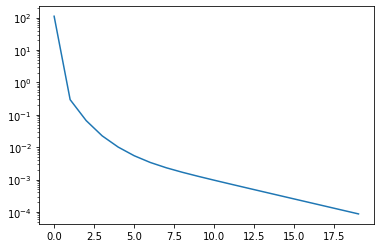

In [105]:
plt.plot(norms)
plt.yscale("log")

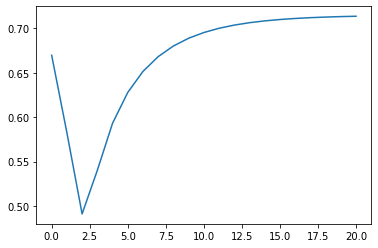

In [106]:
plt.plot([t for t in range(21)],ssims)

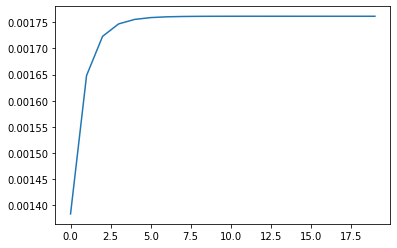

In [107]:
plt.plot(energies)

Tester avec operateur fourier correspondant au gradient de F1 pour tester avec algos pysap. Passer partie reelle des donnees. Proximity_combo dans modopt pour somme des prox.

In [108]:
#Final image
image_rec0 = pysap.Image(data=np.abs(uk))
print(ssims[-1])
image_rec0.show()

0.7136793909835487


# Comparison to other optimization algorithms

In [57]:
regularizer_op = SparseThreshold(linear_op, 6 * 1e-7, thresh_type="soft")
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='analysis',
    verbose=1,
)

Lipschitz constant is 570.4522582220474
The lipschitz constraint is satisfied


In [58]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=y,
    optimization_alg='condatvu',
    num_iterations=200,
)

 - mu:  6e-07
 - lipschitz constant:  570.4522582220474
 - tau:  0.003499854924281129
 - sigma:  0.5
 - rho:  1.0
 - std:  None
 - 1/tau - sigma||L||^2 >= beta/2:  True
 - data:  (512, 512)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7f4ddc380898> - 4
 - max iterations:  200
 - number of reweights:  0
 - primal variable shape:  (512, 512)
 - dual variable shape:  (291721,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:49 Time:  0:00:49


 - final iteration number:  200
 - final cost value:  6.360616549907266e-08
 - converged:  False
Done.
Execution time:  393.43095800000003  seconds
----------------------------------------


In [59]:
image_rec = pysap.Image(data=np.abs(x_final))
recon_ssim = ssim(image_rec, u0)
image_rec.show()
print(recon_ssim)

0.7766223604050768
